In [115]:
# Cargar las librerías necesarias
import importlib
import numpy as np
import statistics 
import matplotlib.pyplot as plt
from outliers import smirnov_grubbs as Grubbs
from numba import njit

#Importa archivos externos
import calculos as calc
importlib.reload(calc)
import fileio
importlib.reload(fileio)
import graf
importlib.reload(graf)

#Variables establecidas necesarias para los cálculos

#Frecuencia de muestreo del PXIe
freq_datos = 1500

#Voltaje mínimo y máximo del barrido de la sonda.
VBmin, VBmax, = -80 , 10 
#Coordenadas de medición con la sonda (m).
radio0 = 0.3070
radio1 = 0.3151
radio2 = 0.2900

z = -0.0125
#Magnitud de campo magnético en punto de muestreo estudiado (Teslas).
B0 = 0.0289
B1 = 0.0274
B2 = 0.0322
#Ángulo poloidal (°)
theta = 55.5
#Ángulo poloidal (rad)
thetarad = theta*np.pi/180
#Diferencia radial entre las puntas
Delta_r = 0.0035
#Distancia poloidal entre puntas d:
d = 0.013
#Nivel de significancia para pruebas estadísticas
alpha = 0.01

#Funciones 
@njit
def tiempos(datos): #Hace los arrays de tiempo para las graficaciones
    f = 15
    T = 1/f
    L = len(datos)
    tiempo = np.linspace(0, T*L,L)
    return tiempo

def Depurar(datos, alpha): #Depura datos anómalos usando la prueba estadística de Grubbs
    datosDep = []
    for i in (range(len(datos))):
        datosDep.append(datos[i])
    Dep = Grubbs.test(datosDep, alpha)
    Outliers = Grubbs.two_sided_test_indices(datosDep, alpha)
    # a = statistics.mean(Dep)
    for i in range(len(Outliers)):
        i = i+1
        if Outliers[i-1] == 0:
            a = statistics.mean([Dep[Outliers[i-1]-i+1],Dep[Outliers[i-1]-i+2]])
            datosDep[Outliers[i-1]]=a
        elif Outliers[i-1] == len(datosDep)-1:
            a = statistics.mean([Dep[Outliers[i-1]-i-1],Dep[Outliers[i-1]-i-2]])
            datosDep[Outliers[i-1]]=a
        else:
            a = statistics.mean([Dep[Outliers[i-1]-i],Dep[Outliers[i-1]-i+1]])
            datosDep[Outliers[i-1]]=a 
    return datosDep

def tilde(datos): #Cálculo de variables tilde
    datostilde = []
    for i in datos:
        a = i - statistics.mean(datos)
        datostilde.append(a)
    return datostilde

def VariablesTurbulencias(datos, freq_datos, VBmin, VBmax, B0, alpha): #Cálculo de variables de turbulencias
    df, segmentos_df = fileio.PreProcesado2(datos, freq_datos, VBmin, VBmax) #Segmentación de las curvas IV
    lista_Iis, lista_vf = calc.Calc_turbulencias(segmentos_df,min_datos=5,v_sup=5,inicio=-40, tol = 0.01, short=True) #Obtención de valores de Isat y Vf, uno por cada segmento

#Depuración de valores
    VfDep = Depurar(lista_vf,alpha)
    ISDep = Depurar(lista_Iis,alpha) 

#Cálculo de variables de corriente de saturación y voltaje flotante tilde
    Vftilde = abs(np.array(tilde(VfDep))) #Graf 1
    Istilde = -abs(np.array(tilde(ISDep))) #Graf 2

#Cálculo del campo eléctrico poloidal
    E_theta = -Vftilde/d  #Graf 3

#Cálculo de la velocidad de fase de las fluctuaciones poloidales
    v_theta = -np.array(VfDep)/(Delta_r*B0) #Graf 5 

#Cálculo del flujo radial turbulento de partículas
    IsEtheta = Istilde*E_theta   

    Gamma_r = statistics.mean(IsEtheta)/B0 #Graf final de puntos
 
#Cálculo de velocidad radial efectiva
    Vr_eff = Gamma_r/ISDep     #Graf 4

#Obtención de array de tiempo para graficación
    Tiempo = tiempos(VfDep)

    return VfDep, ISDep, Gamma_r, abs(E_theta), abs(Vr_eff), abs(v_theta), Tiempo

def grafitriple(X1,X2,X3,Y1,Y2,Y3,ejex,ejey,r,tit,num_corrida): #Gráfico comparativo de parámetros turbulentos a distintos pulsos
    plt.plot(X1, Y1, color = "blue", label="Curva pulso -60 V", marker = ".")
    plt.plot(X2, Y2, color = "red", label="Curva pulso -120 V", marker = ".")
    plt.plot(X3, Y3, color = "green", label="Curva sin pulso", marker = ".")
    plt.xlabel(ejex)
    plt.ylabel(ejey)
    plt.legend(bbox_to_anchor=(1.38,0.6), fontsize='10')
    plt.title(f"Gráfica de {tit} {ejey} para r = {r} m (corrida {num_corrida} en esta posición)", fontsize = 10)
    plt.grid()
    plt.show()

def grafvariables(T1,T2,T3,V1,V2,V3,I1,I2,I3,E1,E2,E3,v1,v2,v3,G1,G2,G3,vt1,vt2,vt3,r,num_corrida): #Graficación de distintos parámetros para cada descarga
    x = 't (s)'
    y1 = r'$V_f\:(\text{V})$'
    tit1 = 'voltaje flotante'
    grafitriple(T1,T2,T3,V1,V2,V3,x,y1,r, tit1,num_corrida)
    y2 = r'$I_s\:(\text{A})$'
    tit2 = 'corriente de saturación iónica'
    grafitriple(T1,T2,T3,I1,I2,I3,x,y2,r, tit2,num_corrida)
    y3 = r'$\tilde{E}_{\theta} \: (\text{N/C})$'
    tit3 = 'campo eléctrico poloidal'
    grafitriple(T1,T2,T3,E1,E2,E3,x,y3,r, tit3,num_corrida)
    y4 = r'$v_r ^{eff} \: (\text{m/s})$'
    tit4 = 'velocidad radial efectiva'
    grafitriple(T1,T2,T3,v1,v2,v3,x,y4,r, tit4,num_corrida)
    y5 = r'$v_\theta ^{ph} \: (\text{m/s})$'
    tit5 = 'velocidad de fase de las fluctuaciones poloidales'
    grafitriple(T1,T2,T3,vt1,vt2,vt3,x,y5,r, tit5,num_corrida)    

    print("Valores del flujo radial turbulento de partículas (Gamma):", '\n', f"Para r = {r} m (corrida {num_corrida} en esta posición)", '\n',"Pulso de -60 V:", G1, '\n',"Pulso de -120 V:", G2, '\n',"Sin pulso:", G3, '\n', '\n')


In [116]:
###Primera corrida en cada posición

# Primer posición:
#r = 0.307 m, 1 = 60V, 2 = 120V, 3 = SinV
Vf1, IS1, Gamma1 , Etheta1 , veff1, vtheta1, time1 = VariablesTurbulencias("PruebasSondaSimple_317.xlsx", freq_datos, VBmin, VBmax, B0, alpha)
Vf2, IS2, Gamma2 , Etheta2 , veff2, vtheta2, time2 = VariablesTurbulencias("SondaPulso120V.xlsx", freq_datos, VBmin, VBmax, B0, alpha)
Vf3, IS3, Gamma3 , Etheta3 , veff3, vtheta3, time3 = VariablesTurbulencias("SondaSinPulso.xlsx", freq_datos, VBmin, VBmax, B0, alpha)

# Segunda posición:
# r = 0.3157 m, 4 = 60V, 5 = 120V, 6 = SinV
Vf4, IS4, Gamma4 , Etheta4 , veff4, vtheta4, time4 = VariablesTurbulencias("PruebasSondaSimple_272.xlsx", freq_datos, VBmin, VBmax, B1, alpha)
Vf5, IS5, Gamma5 , Etheta5 , veff5, vtheta5, time5 = VariablesTurbulencias("PruebasSondaSimple_270.xlsx", freq_datos, VBmin, VBmax, B1, alpha)
Vf6, IS6, Gamma6 , Etheta6 , veff6, vtheta6, time6 = VariablesTurbulencias("PruebasSondaSimple_263.xlsx", freq_datos, VBmin, VBmax, B1, alpha)

# Tercer posición:
#r = 0.29 m, 7 = 60V, 8 = 120V, 9 = SinV
Vf7, IS7, Gamma7 , Etheta7 , veff7, vtheta7, time7 = VariablesTurbulencias("PruebasSondaSimple_278_60.xlsx", freq_datos, VBmin, VBmax, B2, alpha)
Vf8, IS8, Gamma8 , Etheta8 , veff8, vtheta8, time8 = VariablesTurbulencias("PruebasSondaSimple_276_120.xlsx", freq_datos, VBmin, VBmax, B2, alpha)
Vf9, IS9, Gamma9 , Etheta9 , veff9, vtheta9, time9 = VariablesTurbulencias("PruebasSondaSimple_279_0.xlsx", freq_datos, VBmin, VBmax, B2, alpha)

# # Pruebas con señal cuadrada:
#  # r = 0,29 m, ambas a 60 V, señal cuadrada
# Vf10, IS10, Gamma10 , Etheta10 , veff10, time10 = VariablesTurbulencias("PruebasSondaSimple_313.xlsx", freq_datos, VBmin, VBmax, B2, alpha)
# Vf11, IS11, Gamma11 , Etheta11 , veff11, time11 = VariablesTurbulencias("PruebasSondaSimple_315.xlsx", freq_datos, VBmin, VBmax, B2, alpha)

###Segunda corrida en cada posición

#Primer posición:
#r = 0.307 m, 10 = 60V, 11 = 120V, 12 = SinV 
Vf10, IS10, Gamma10 , Etheta10 , veff10, vtheta10, time10 = VariablesTurbulencias("PruebasSondaSimple_337.xlsx", freq_datos, VBmin, VBmax, B0, alpha)
Vf11, IS11, Gamma11 , Etheta11 , veff11, vtheta11, time11 = VariablesTurbulencias("PruebasSondaSimple_339.xlsx", freq_datos, VBmin, VBmax, B0, alpha)
Vf12, IS12, Gamma12 , Etheta12 , veff12, vtheta12, time12 = VariablesTurbulencias("PruebasSondaSimple_341.xlsx", freq_datos, VBmin, VBmax, B0, alpha)

#Segunda posición:
# r = 0.3157 m, 13 = 60V, 14 = 120V, 15 = SinV
Vf13, IS13, Gamma13 , Etheta13 , veff13, vtheta13, time13 = VariablesTurbulencias("PruebasSondaSimple_347.xlsx", freq_datos, VBmin, VBmax, B1, alpha)
Vf14, IS14, Gamma14 , Etheta14 , veff14, vtheta14, time14 = VariablesTurbulencias("PruebasSondaSimple_345.xlsx", freq_datos, VBmin, VBmax, B1, alpha)
Vf15, IS15, Gamma15 , Etheta15 , veff15, vtheta15, time15 = VariablesTurbulencias("PruebasSondaSimple_343.xlsx", freq_datos, VBmin, VBmax, B1, alpha)

#Tercer posición:
#No hay 

C:\Users\andre\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\andre\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\andre\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\andre\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\andre\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

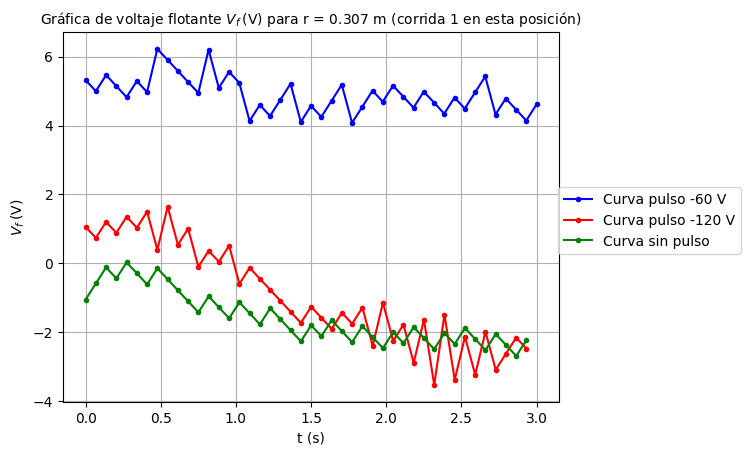

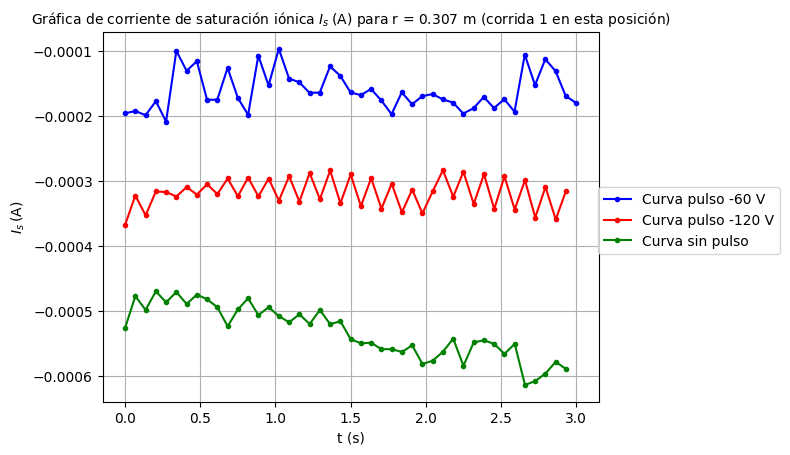

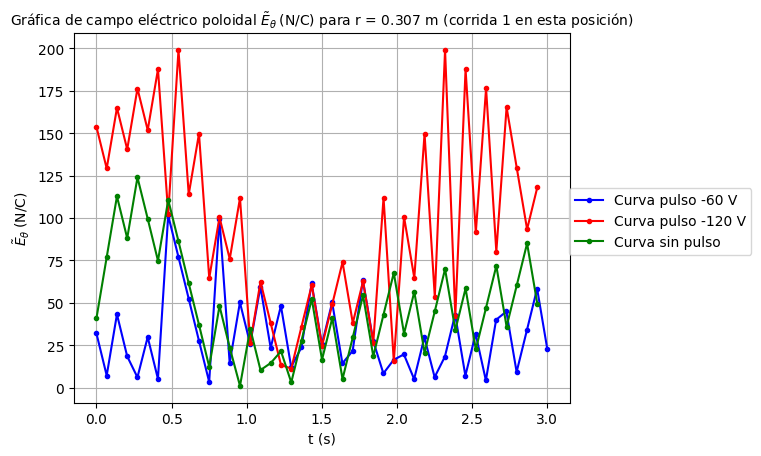

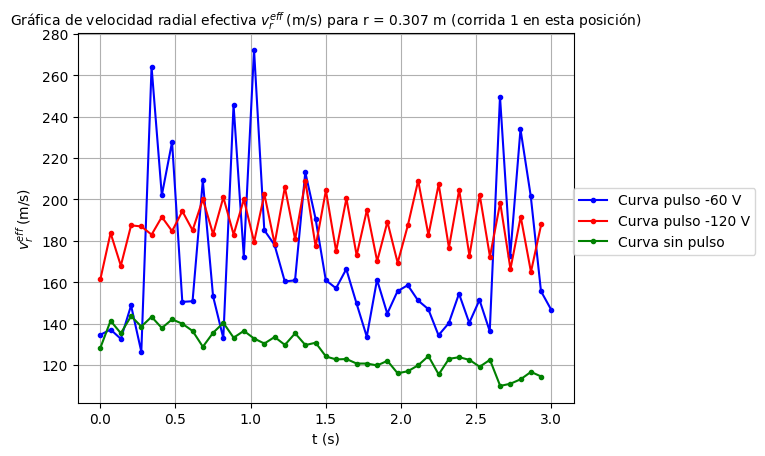

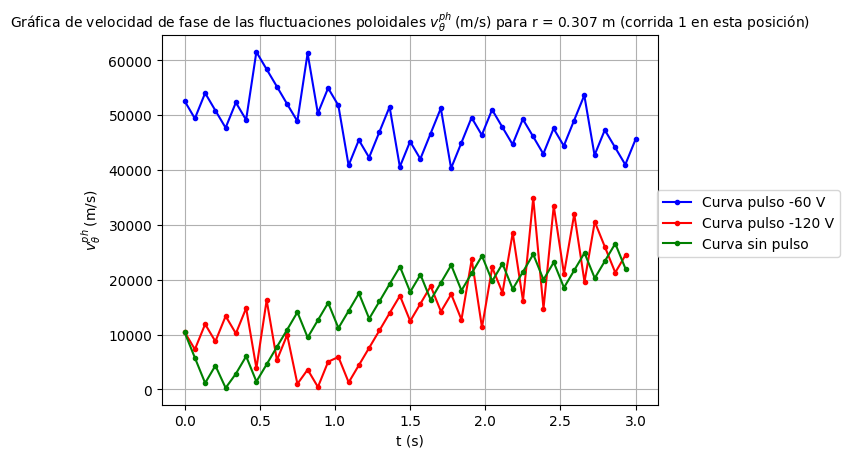

Valores del flujo radial turbulento de partículas (Gamma): 
 Para r = 0.307 m (corrida 1 en esta posición) 
 Pulso de -60 V: 0.026384105628482955 
 Pulso de -120 V: 0.05927979434682515 
 Sin pulso: 0.0674656816518192 
 



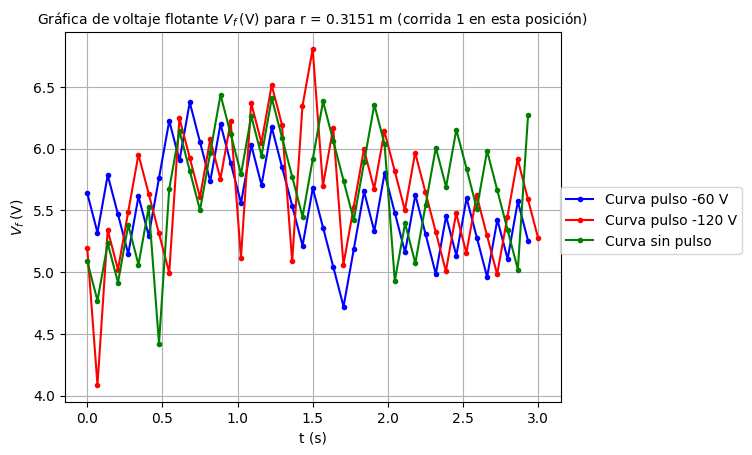

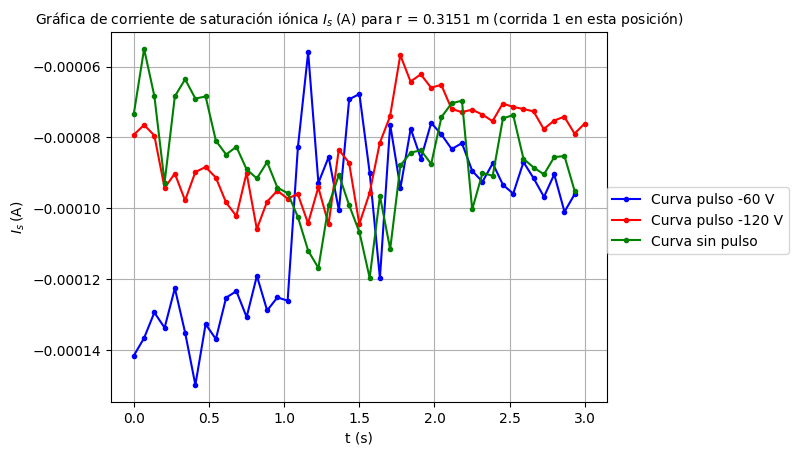

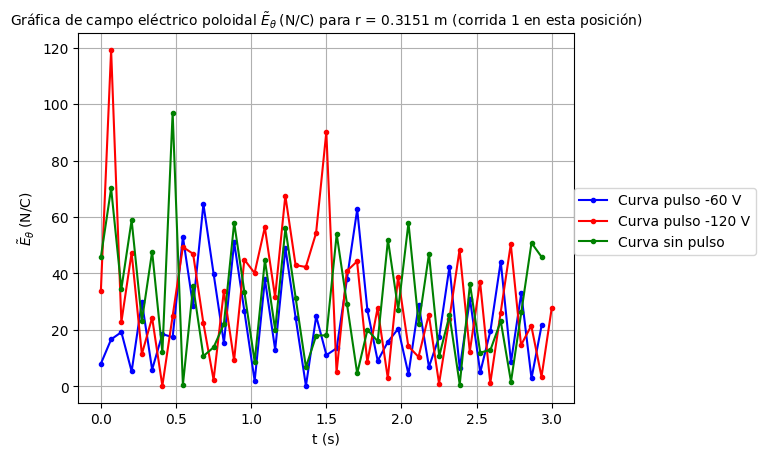

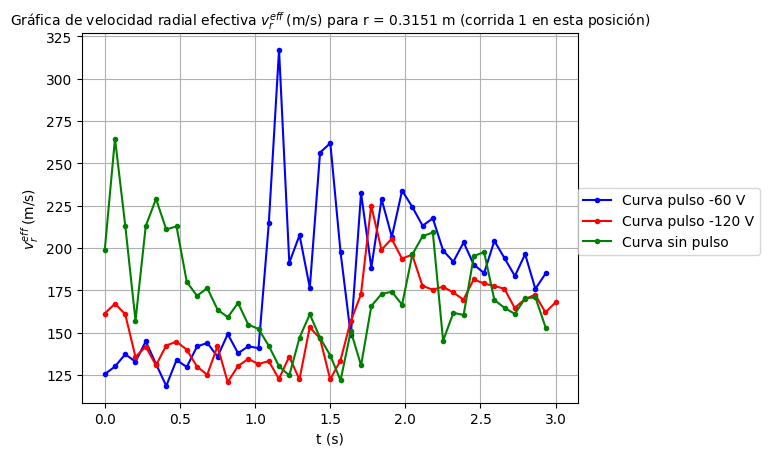

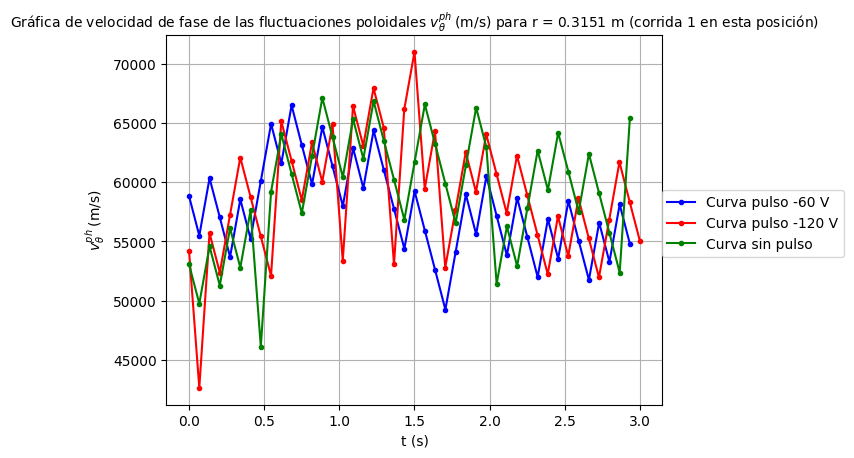

Valores del flujo radial turbulento de partículas (Gamma): 
 Para r = 0.3151 m (corrida 1 en esta posición) 
 Pulso de -60 V: 0.017750013639397363 
 Pulso de -120 V: 0.012778843352089179 
 Sin pulso: 0.01456390245201882 
 



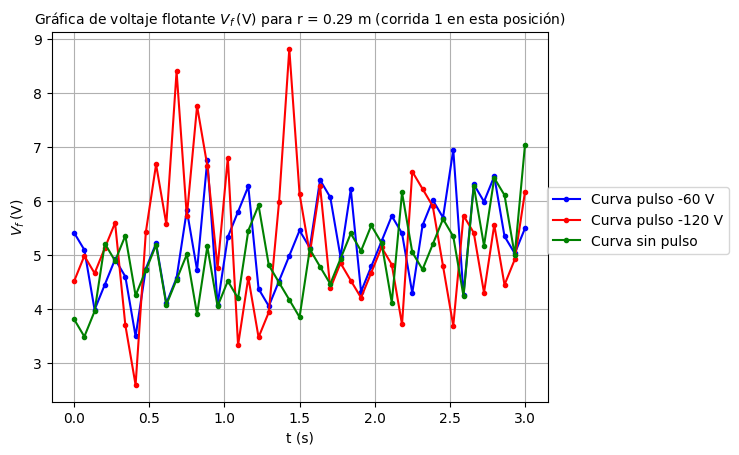

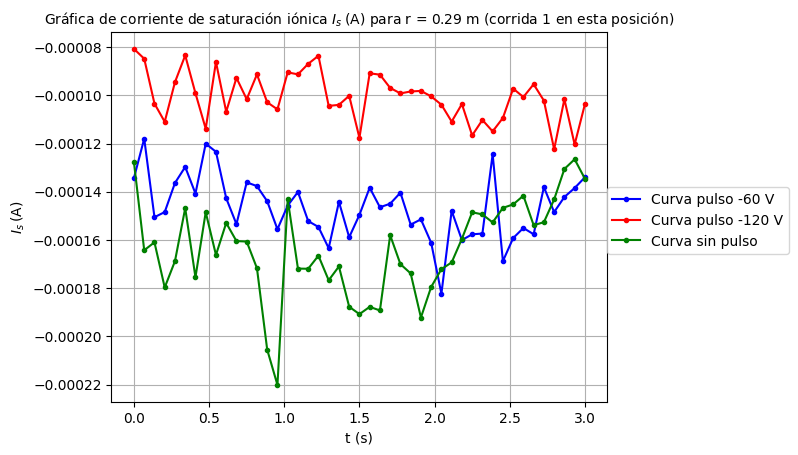

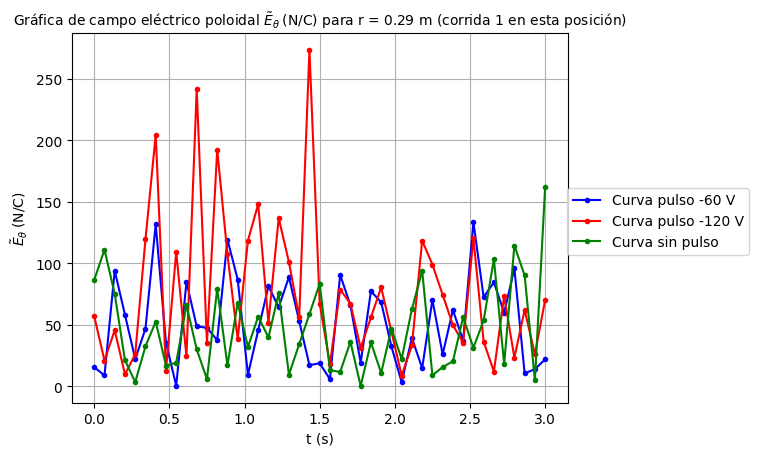

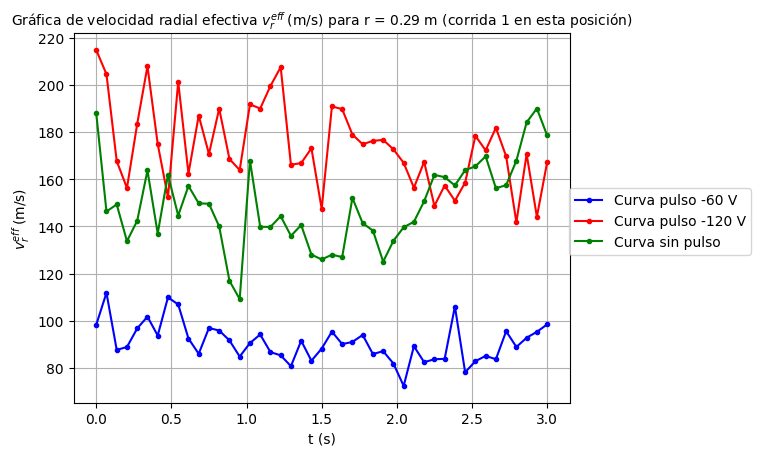

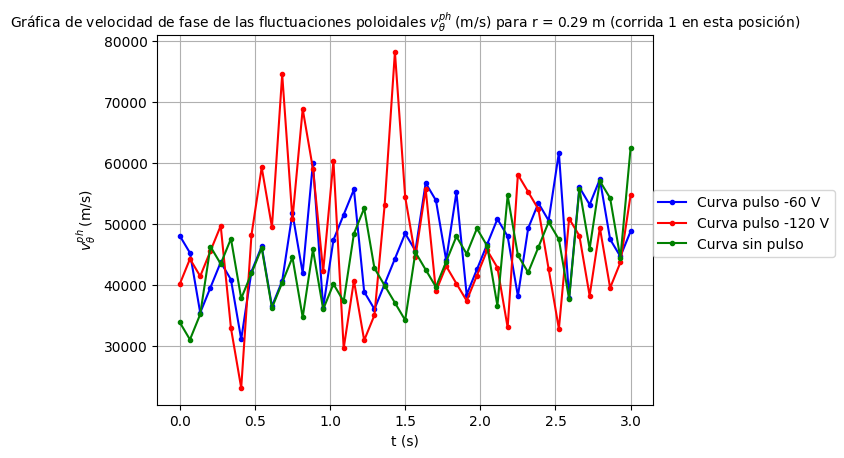

Valores del flujo radial turbulento de partículas (Gamma): 
 Para r = 0.29 m (corrida 1 en esta posición) 
 Pulso de -60 V: 0.01319521181261075 
 Pulso de -120 V: 0.017343518045569432 
 Sin pulso: 0.02403926750337374 
 



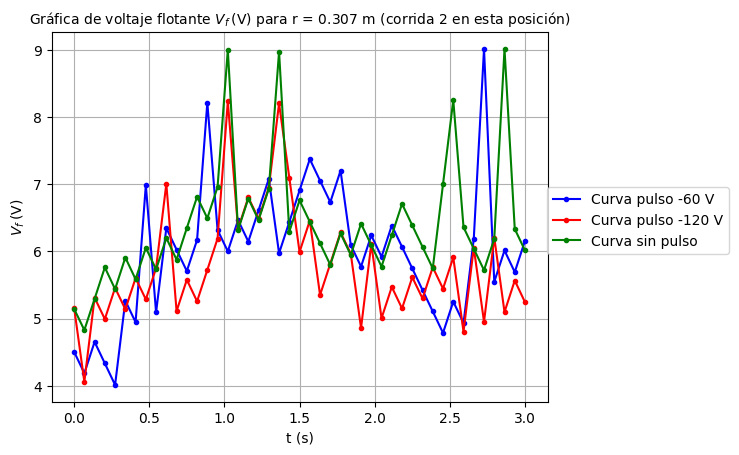

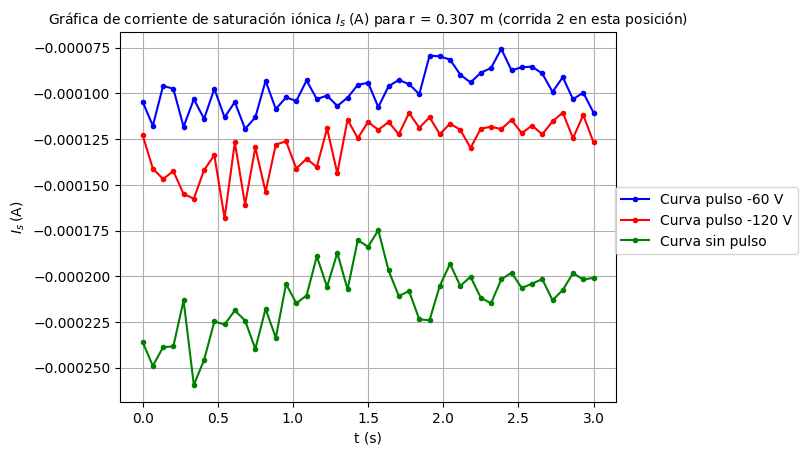

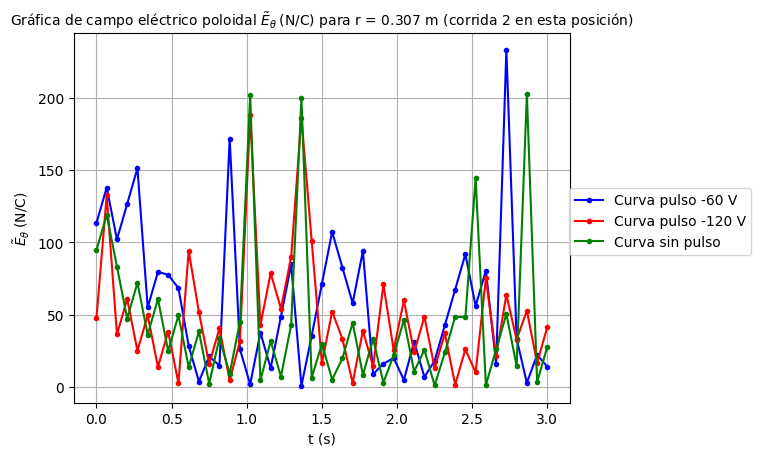

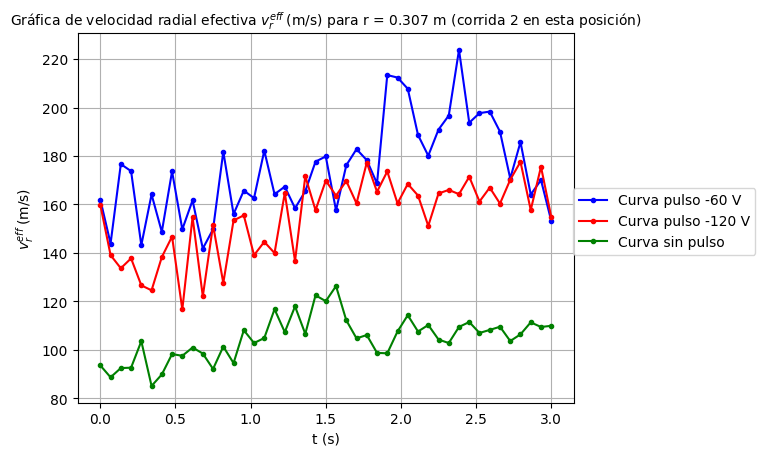

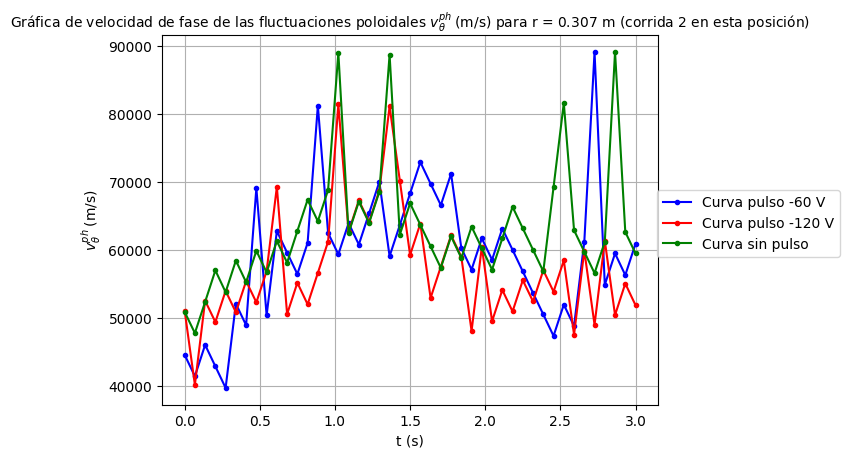

Valores del flujo radial turbulento de partículas (Gamma): 
 Para r = 0.307 m (corrida 2 en esta posición) 
 Pulso de -60 V: 0.016930630411034226 
 Pulso de -120 V: 0.01962394633756392 
 Sin pulso: 0.022077647593342 
 



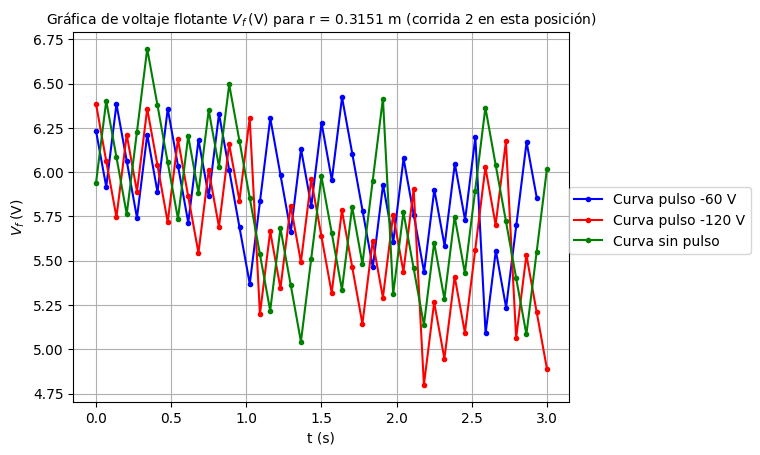

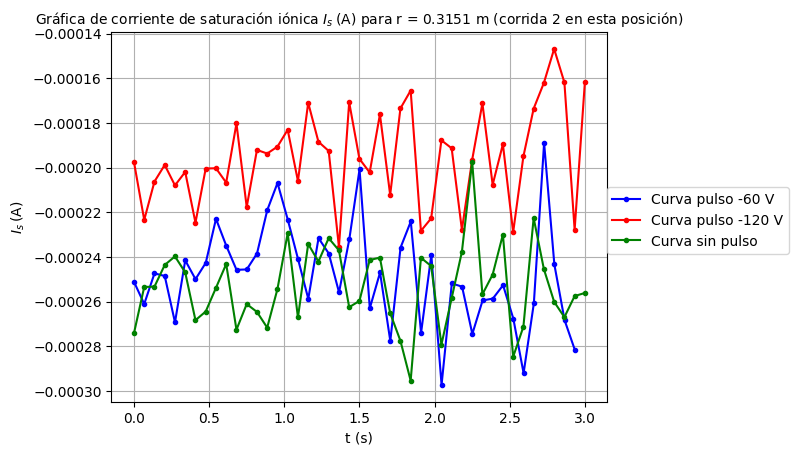

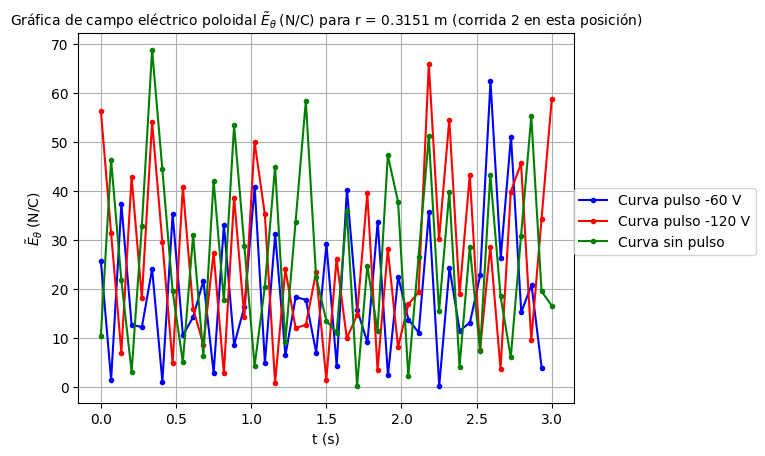

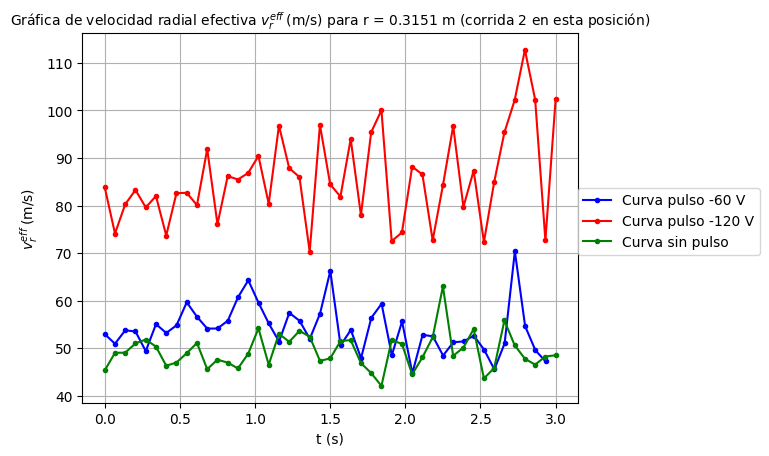

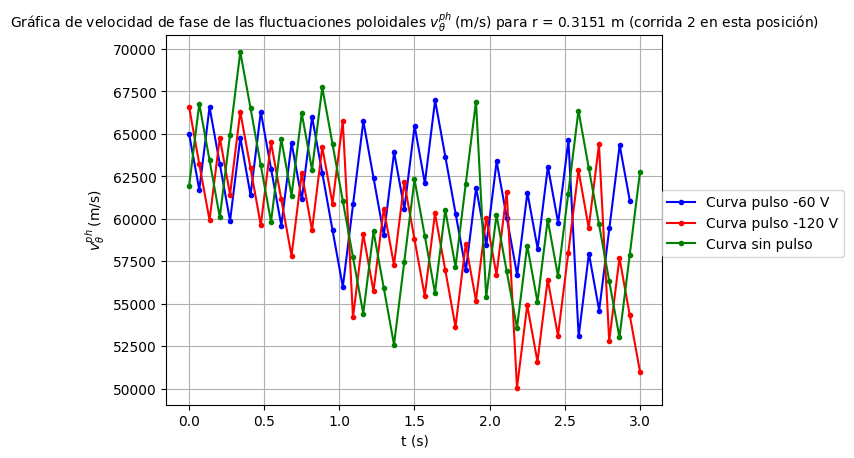

Valores del flujo radial turbulento de partículas (Gamma): 
 Para r = 0.3151 m (corrida 2 en esta posición) 
 Pulso de -60 V: 0.01329497782547267 
 Pulso de -120 V: 0.016553015964979725 
 Sin pulso: 0.012422015689189126 
 



In [117]:
#Graficación de variables de turbulencia para la primer corrida en cada posición
grafvariables(time1,time2,time3,Vf1,Vf2,Vf3,IS1,IS2,IS3,Etheta1,Etheta2,Etheta3,veff1,veff2,veff3,Gamma1,Gamma2,Gamma3,vtheta1,vtheta2,vtheta3,radio0, 1)
grafvariables(time4,time5,time6,Vf4,Vf5,Vf6,IS4,IS5,IS6,Etheta4,Etheta5,Etheta6,veff4,veff5,veff6,Gamma4,Gamma5,Gamma6,vtheta4,vtheta5,vtheta6,radio1, 1)
grafvariables(time7,time8,time9,Vf7,Vf8,Vf9,IS7,IS8,IS9,Etheta7,Etheta8,Etheta9,veff7,veff8,veff9,Gamma7,Gamma8,Gamma9,vtheta7,vtheta8,vtheta9,radio2, 1)

#Graficación de variables de turbulencia para la primer corrida en la segunda posición
grafvariables(time10,time11,time12,Vf10,Vf11,Vf12,IS10,IS11,IS12,Etheta10,Etheta11,Etheta12,veff10,veff11,veff12,Gamma10,Gamma11,Gamma12,vtheta10,vtheta11,vtheta12,radio0, 2)
grafvariables(time13,time14,time15,Vf13,Vf14,Vf15,IS13,IS14,IS15,Etheta13,Etheta14,Etheta15,veff13,veff14,veff15,Gamma13,Gamma14,Gamma15,vtheta13,vtheta14,vtheta15,radio1, 2)

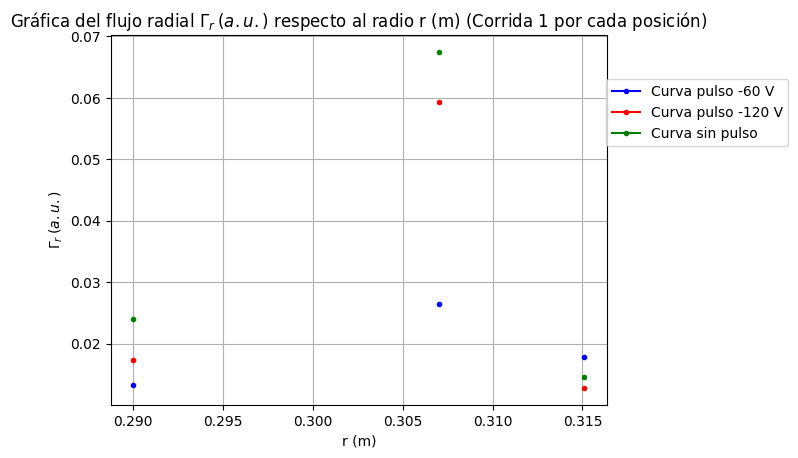

In [127]:
#Graficación de Gamma para distintos r

#Primera corrida en cada posición
plt.plot(radio0, Gamma1, marker = ".", color = "blue", label="Curva pulso -60 V")
plt.plot(radio0, Gamma2, marker = ".",color = "red", label="Curva pulso -120 V")
plt.plot(radio0, Gamma3, marker = ".", color = "green", label="Curva sin pulso")
plt.plot(radio1, Gamma4, marker = ".", color = "blue")
plt.plot(radio1, Gamma5, marker = ".", color = "red")
plt.plot(radio1, Gamma6, marker = ".", color = "green")
plt.plot(radio2, Gamma7, marker = ".", color = "blue")
plt.plot(radio2, Gamma8, marker = ".", color = "red")
plt.plot(radio2, Gamma9, marker = ".", color = "green")

#Segunda corrida en cada posición

# plt.plot(radio0, Gamma10, marker = ".", color = "magenta", label="Curva pulso -60 V")
# plt.plot(radio0, Gamma11, marker = ".",color = "brown", label="Curva pulso -120 V")
# plt.plot(radio0, Gamma12, marker = ".", color = "orange", label="Curva sin pulso")
# plt.plot(radio1, Gamma13, marker = ".", color = "magenta")
# plt.plot(radio1, Gamma14, marker = ".", color = "brown")
# plt.plot(radio1, Gamma15, marker = ".", color = "orange")

gammay = r'$\Gamma_r\: (a.u.)$'
plt.title(f"Gráfica del flujo radial {gammay} respecto al radio r (m) (Corrida 1 por cada posición)")
plt.xlabel("r (m)")
plt.ylabel(gammay)
plt.legend(bbox_to_anchor=(1.38, 0.9), fontsize='10')
plt.grid()
plt.show()
